# Lab work 4
## Numerical interpolation

## 1. Lagrange polynomial

Interpolation task:
We have some points $ x_i, i = 1...n $ and values of function in them $ y_i = f(x_i) $ and have to find an interpolant -  function $F:$ $ F(x_i) = y_i $  
Firstly, let's make an interpolation polynomial in the Lagrange form: $ L = \sum\limits^{n}_{i=0} y_i l_i(x) $,  
where $ l_i(x) = \frac{(x-x_0)...(x-x_{i-1})(x-x_{i+1})...(x-x_n)}{(x_i-x_0)...(x_i-x_{i-1})(x_i-x_{i+1})...(x_i-x_n)}  = \
\begin{cases}
   1, x = x_i\\
   0, x = x_j, j \ne i
 \end{cases}$ 
are called Lagrange basis polynomials


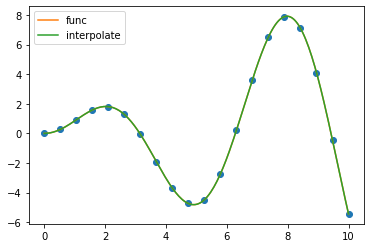

accuracy =  1.453780722471265e-07


In [2]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import scipy.interpolate as sci

def Lagrange(x, y, x0):
    n = len(x)
    L = 0
    for i in range(n):
        l = 1
        for j in range(i):
            l *= (x0 - x[j]) / (x[i] - x[j])
        for j in range(i+1, n):
            l *= (x0 - x[j]) / (x[i] - x[j])
        L += y[i] * l
    return L
    
def createData(f, a, b, n):
    x = np.linspace(a, b, n)
    y = f(x)
    return x, y

n = 20
beg = 0
end = 10
func = lambda x: x*np.sin(x)
x, y = createData(func, beg, end, n)
xfine = np.linspace(beg, end, 10*n)
yfine = Lagrange(x, y, xfine)

plt.plot(x, y , 'o')
plt.plot(xfine, func(xfine), label = 'func')
plt.plot(xfine, yfine, label = 'interpolate')
plt.legend()
plt.show()
print("accuracy = ", max(abs(yfine - func(xfine))))

## 2. Newton polynomial

Secondly, let's make the Newton interpolation polynomial: $ N = f(x_0) + (x-x_0)f(x_0, x_1) + (x-x_0)(x-x_1)f(x_0,x_1,x_2) + ... + (x-x_0)...(x-x_{n-1})f(x_0...x_n) = \sum\limits^{n}_{i=0} \Delta_i n_i(x) $,  
where $ \Delta_i = f(x_0...x_i) $ is called divided difference and has recursive formula: $ f(x_0...x_i) = \frac{f(x_1...x_i) - f(x_0...x_{i-1})}{x_i - x_0}, f(x_0) = f(x_0) $  
or can be calculated as $ \Delta_i = \sum\limits_{j = 0}^i \frac{y_j}{\prod\limits_{k \ne j}^i (x_j-x_k)} $  
and $ n_i = \prod\limits_{j = 0}^{i-1} (x-x_j) $ - Newton basis polynomials  

This method is more comfortable, because it is easy to add or delete some points.

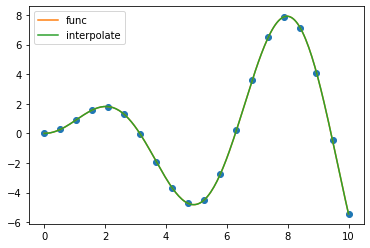

accuracy =  6.64515547654787e-05


In [3]:
def divDiff(x, y, k):
    delta = 0
    for i in range(k):
        prod = 1
        for j in range(i):
            prod *= (x[i]-x[j])
        for j in range(i+1, k):
            prod *= (x[i]-x[j])
        delta += y[i] / prod
    return delta

def Newton(x, y, x0):
    k = len(x)
    N = y[0]
    for j in range(1, k):
        n = 1
        for i in range(j-1):
            n *= x0 - x[i]
        N += divDiff(x, y, j) * n
    return N

n = 20
beg = 0
end = 10
func = lambda x: x*np.sin(x)
x, y = createData(func, beg, end, n)
xfine = np.linspace (beg, end, 10*n)
yfine = Newton(x, y, xfine)

plt.plot(x, y , 'o')
plt.plot(xfine, func(xfine), label = 'func')
plt.plot(xfine, yfine, label = 'interpolate')
plt.legend()
plt.show()
print("accuracy = ", max(abs(yfine - func(xfine))))

## 3. Spline interpolation

Spline is a function, which domain of definition is divided into a finite number of intervals, where it coincide with some algebraic polynomial. We will consider cubic spline.
In this way we take each two nearby points and make a cubic polynomial. 
$$ S_i(x) = a_i + b_i(x-x_i) + c_i(x-x_i)^2 + d_i(x-x_i)^3 $$
$$ S(x_i) = a_i, S'(x_i) = b_i, S''(x_i) = 2c_i, S'''(x_i) = 6d_i , i = 1...n $$

Its coefficients are determined from the smoothness condition of the function and interpolation condition:
$$ S_i(x_{i-1}) = S_i(x_i), S'(x_{i-1}) = S'(x_i), S''(x_{i-1}) = S''(x_i), S(x_i) = f(x_i) $$

Denoting $h_i$ as $ h_i = x_i - x_{i-1}$, we get next conditions:
$$a_i = y_i $$
$$ b_i = \frac{a_i-a_{i-1}}{h_i} - \frac{2c_{i-1} + c_{i}}{3}h_i $$
$$ d_i = \frac{c_i - c_{i-1}}{3h_i} $$
$$ c_{i-1}h_i + 2c_i(h_i + h_{i+1}) + c_{i+1}h_{i+1} = 3 \left(\frac{a_{i+1}-a_{i}}{h_{i+1}} - \frac{a_{i}-a_{i-1}}{h_{i}}\right) $$
$$ c_n = 0, c_1 = 0 $$

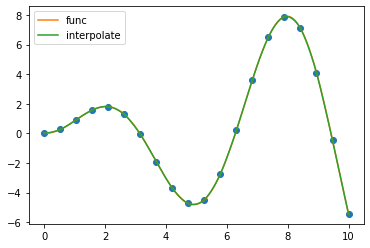

accuracy =  0.05185574726397468


In [4]:
def tridiag(A, b):
    n = len(b)
    alpha = np.diagonal(A, offset = -1)
    beta = np.diagonal(A)
    gamma = np.diagonal(A, offset = 1)
    
    P = np.zeros(n)
    P[0] = -gamma[0] / beta[0]
    for i in range(1, n-1):
        P[i] = gamma[i] / (-beta[i] - alpha[i-1]*P[i-1])
    P[n-1] = 0
    
    Q = np.zeros(n)
    Q[0] = b[0] / beta[0]
    for i in range(1, n):
        Q[i] = (alpha[i-1]*Q[i-1] - b[i]) / (-beta[i] - alpha[i-1]*P[i-1])
        
    x = np.zeros(n)
    x[n-1] = Q[n-1]
    for i in range(n-2, -1, -1):
        x[i] = P[i]*x[i+1] + Q[i]
    
    return x

import numpy.linalg as la
def cubicSpline(x, y):
    n = len(x)
    a = y
    
    A = np.zeros((n-2, n-2))
    for i in range(n-2):
        A[i][i] = 2*(x[i+2]-x[i])
    for i in range(1, n-2):
        A[i][i-1] = x[i+2] - x[i]
    for i in range(n-3):
        A[i][i+1] = x[i+1] - x[i]


    f = []
    for i in range(1, n-1):
        f.append(3*((y[i+1]-y[i])/(x[i+1]-x[i]) 
                    - (y[i]-y[i-1])/(x[i]-x[i-1])))

    c = tridiag(A, f)
    c = np.insert(c, 0, 0)
    c = np.append(c, 0)
    
    b = []
    for i in range(n-1):
        b.append((y[i+1] - y[i])/(x[i+1] - x[i])
                 - (2*c[i] + c[i+1])*(x[i+1] - x[i])/3)
    
    d = []
    for i in range(n-1):
        d.append((c[i+1] - c[i]) / 3 / (x[i+1] - x[i]))
    return [a, b, c, d]

                 
n = 20
beg = 0
end = 10
func = lambda x: x*np.sin(x)
x, y = createData(func, beg, end, n)
xfine = np.linspace (beg, end, 10*n)

a, b, c, d = cubicSpline(x, y)

yfine = []
for x0 in xfine:
    index = int(x0 // ((end-beg) / (n-1)))
    if index == n-1:
        index -= 1
    yfine.append(a[index] + b[index]*(x0-x[index]) 
                 + c[index]*((x0-x[index])**2) + d[index]*((x0-x[index])**3))
    
plt.plot(x, y, 'o')
plt.plot(xfine, func(xfine), label = 'func')
plt.plot(xfine, yfine, label = 'interpolate')
plt.legend()
plt.show()
print("accuracy = ", max(abs(yfine - func(xfine))))